## RANDOM FOREST

In this notebook we will perform a Random Forest model which is an effective classification model. We will use a telecommunications dataset for predicting customer churn. I found this dataset on some Kaggle page, the description of teh data said the following:

This is a historical customer dataset where each row represents one customer. The data is relatively easy to understand, and you may uncover insights you can use immediately. Typically, it is less expensive to keep customers than acquire new ones, so the focus of this analysis is to predict the customers who will stay with the company.

This data set provides information to help you predict what behavior will help you to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

The dataset includes information about:

* Customers who left within the last month – the column is called Churn

* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

* Customer account information – how long they had been a customer, contract, payment method, paperless billing, monthly charges, and total charges

* Demographic info about customers – gender, age range, and if they have partners and dependents


First we import the neccesary libraries

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
from sklearn import metrics
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

This function will calculate the accuracy of the training and testing data given a model.


In [2]:
def get_accuracy(X_train, X_test, y_train, y_test, model):
    return  {"test Accuracy":round(metrics.accuracy_score(y_test, model.predict(X_test)), 2),
             "trian Accuracy": round(metrics.accuracy_score(y_train, model.predict(X_train)), 2)}

# REVIEW ABOVE FROM HERE

Load data from csv file

In [3]:
churn_df = pd.read_csv('ChurnData.csv')
# churn_df.shape #(200, 29)

#Now let's see some rows
churn_df.head()

,tenure,age,address,income,ed,employ,equip,callcard,wireless,longmon,...,pager,internet,callwait,confer,ebill,loglong,logtoll,lninc,custcat,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,4.40,...,1.0,0.0,1.0,1.0,0.0,1.482,3.033,4.913,4.0,1.0
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,9.45,...,0.0,0.0,0.0,0.0,0.0,2.246,3.240,3.497,1.0,1.0
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,6.30,...,0.0,0.0,0.0,1.0,0.0,1.841,3.240,3.401,3.0,0.0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,6.05,...,1.0,1.0,1.0,1.0,1.0,1.800,3.807,4.331,4.0,0.0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,7.10,...,0.0,0.0,1.0,1.0,0.0,1.960,3.091,4.382,3.0,0.0


Now we'll see some info of the dataset

In [4]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tenure    200 non-null    float64
 1   age       200 non-null    float64
 2   address   200 non-null    float64
 3   income    200 non-null    float64
 4   ed        200 non-null    float64
 5   employ    200 non-null    float64
 6   equip     200 non-null    float64
 7   callcard  200 non-null    float64
 8   wireless  200 non-null    float64
 9   longmon   200 non-null    float64
 10  tollmon   200 non-null    float64
 11  equipmon  200 non-null    float64
 12  cardmon   200 non-null    float64
 13  wiremon   200 non-null    float64
 14  longten   200 non-null    float64
 15  tollten   200 non-null    float64
 16  cardten   200 non-null    float64
 17  voice     200 non-null    float64
 18  pager     200 non-null    float64
 19  internet  200 non-null    float64
 20  callwait  200 non-null    float6

As we can see from above, there are no object dtype, and our target vararibale is the churn column.

### EDA and selection


Now we will perform a correlation matrix to visualizate the most useful variables.

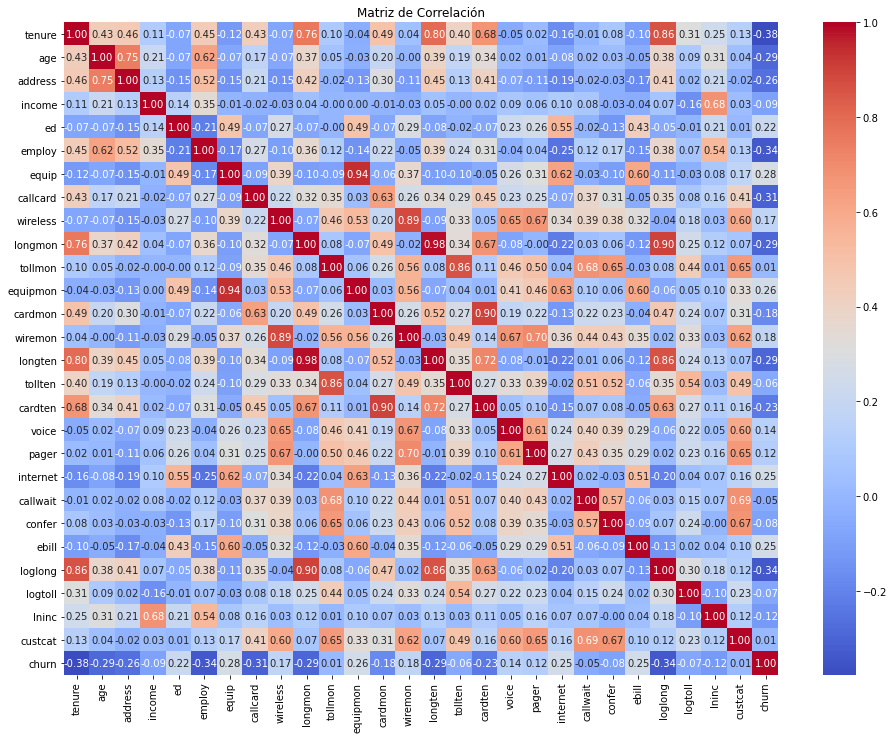

In [5]:
correlation_matrix = churn_df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

Now let's select some features for the modeling. Also, we need to change the target data type to be an integer, for the algorithm.

In [6]:
# churn_df = churn_df[['tenure', 'age', 'address', 'employ', 'callcard', 'longmon', 'longten', 'cardten', 'loglond','churn']]
churn_df = churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip', 'callcard', 'wireless','churn']]
churn_df['churn'] = churn_df['churn'].astype('int')
print(churn_df.shape)
#We see some colums
churn_df.head()

(200, 10)


,tenure,age,address,income,ed,employ,equip,callcard,wireless,churn
0,11.0,33.0,7.0,136.0,5.0,5.0,0.0,1.0,1.0,1
1,33.0,33.0,12.0,33.0,2.0,0.0,0.0,0.0,0.0,1
2,23.0,30.0,9.0,30.0,1.0,2.0,0.0,0.0,0.0,0
3,38.0,35.0,5.0,76.0,2.0,10.0,1.0,1.0,1.0,0
4,7.0,35.0,14.0,80.0,2.0,15.0,0.0,1.0,0.0,0


### Select random variables 

Now we select just some ramdom variables to prove the Baggin model first.

In [7]:
X=churn_df[['tenure', 'age', 'address', 'income', 'ed', 'employ', 'equip']]
y = churn_df['churn']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: churn, dtype: int32

We split our dataset into train and test set.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print ('Train set', X_train.shape,  y_train.shape)
print ('Test set', X_test.shape,  y_test.shape)

Train set (140, 7) (140,)
Test set (60, 7) (60,)


### Bagging  Model


Now we will perform a bagging model, bagging improves models that suffer from overfitting and we will compare to Decition Tree model.

In [9]:
n_estimators=20
#We create the bagging object
Bag= BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion="entropy", max_depth = 4,random_state=2),
                       n_estimators=n_estimators,random_state=0,bootstrap=True)

We fit the model:


In [10]:
Bag.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        max_depth=4,
                                                        random_state=2),
                  n_estimators=20, random_state=0)

We predict using the X_test set.


In [11]:
Bag.predict(X_test)

array([0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

Now we use the function, that we defined above and we see the training accuracy is slightly better.

In [12]:
print(get_accuracy(X_train, X_test, y_train, y_test,  Bag))

{'test Accuracy': 0.73, 'trian Accuracy': 0.91}


### Random  Forest


Now we will use a Random Frest model to compare the accuracy and general score with the results of the bagging model.

We create the Random Forest object.

In [13]:
model = RandomForestClassifier( max_features=7, n_estimators=20, random_state=0)
#We train the model
model.fit(X_train,y_train)

RandomForestClassifier(max_features=7, n_estimators=20, random_state=0)

We obtain the training and testing accuracy.


In [14]:
print(get_accuracy(X_train, X_test, y_train, y_test, model))

{'test Accuracy': 0.78, 'trian Accuracy': 0.99}


As we can see from above the model Random Forest does better than Bagging.

### Random forest to predict cancer 

The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. 

The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)\[[http://mlearn.ics.uci.edu/MLRepository.html](http://mlearn.ics.uci.edu/MLRepository.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)]. 

We load the dataset.

In [15]:
df = pd.read_csv('cell_samples.csv')
df.head()
# df.shape #(699, 11)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Now let's see the dtypes of our data.

In [16]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Now let's drop the column object dtype.

In [17]:
# df= df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
# df = df.drop('BareNuc', axis=1)


We obtain the features and the target variable into X ans y.

In [18]:
X = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BlandChrom', 'NormNucl', 'Mit']]
y=df['Class']
print(X.shape, y.shape)

(699, 8) (699,)


Now we split the data into training and testing sets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print (X_train.shape, X_test.shape)

(559, 8) (140, 8)


We will use GridSearchCV to search the right parameters of the model.

Now we create a RandomForestClassifier object and the list of parameters.

In [20]:
model = RandomForestClassifier()
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Now we use GridSearch to search over specified parameter values.

In [21]:
param_grid = {'n_estimators':[2*n+1 for n in range(20)],
             'max_depth'    :[2*n+1 for n in range(10) ],
             'max_features' :["auto", "sqrt", "log2"]}

We create the grid search object and fit it.

In [22]:
search = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy')
search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

We can see the best accuracy score of the searched parameters was 0.97%


In [23]:
search.best_score_

0.9695785070785071

The best parameter values are:


In [24]:
search.best_params_

{'max_depth': 13, 'max_features': 'sqrt', 'n_estimators': 31}

Lastly we calculate accuracy on the test data using the test data:


In [25]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.94, 'trian Accuracy': 1.0}


### Random Forest to predict best medication

I found this dataset somewhere on Kaggle, the description says that:

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and you can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.

Fisrt we load the dataset. 

In [26]:
df = pd.read_csv('drug200.csv')
#We see some rows
df.head()
# df.shape #(200, 6)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


We see from the above result that we need to perform some variable transformations.

Fisrt let's create the X and y for our dataset:


In [27]:
X = df[['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']].values
y = df["Drug"]
print(X.shape, y.shape)

(200, 5) (200,)


Now we use a LabelEncode to turn categorical features into numerical.

In [28]:
le_sex = preprocessing.LabelEncoder()
le_sex.fit(['F','M'])
X[:,1] = le_sex.transform(X[:,1]) 

le_BP = preprocessing.LabelEncoder()
le_BP.fit([ 'LOW', 'NORMAL', 'HIGH'])
X[:,2] = le_BP.transform(X[:,2])

le_Chol = preprocessing.LabelEncoder()
le_Chol.fit([ 'NORMAL', 'HIGH'])
X[:,3] = le_Chol.transform(X[:,3]) 

We split the data into training and testing data.

In [29]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print (X_train.shape,  X_test.shape)

(160, 5) (40, 5)


We use GridSearch to search over specified parameter values.

In [30]:
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}

Create a object of the model in this case will be a random forest.


In [31]:
model = RandomForestClassifier()

<details><summary>Click here for the solution</summary>

```python
model = RandomForestClassifier()

```

</details>


We create GridSearchCV object and fit the model with X_train and y_train.

In [32]:
search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
#We fit the model to search
search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                          23, 25, 27, 29, 31, 33, 35, 37, 39]},
             scoring='accuracy')

Now we can find the best parameter values:

In [33]:
search.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 13}

And we see the accuracy of the test and train data.

In [34]:
print(get_accuracy(X_train, X_test, y_train, y_test, search.best_estimator_))

{'test Accuracy': 0.92, 'trian Accuracy': 1.0}
